In [17]:
%load_ext autoreload
%autoreload 2
import numpy as np
from source.read_HAR_dataset import DatasetHARUML20
from source.read_pamap2 import DatasetPAMAP2
from source.read_open_dataset import DatasetOpenDataset, openDatasetParticipants
from source.tserie import TSerie
from source.models.manifold.umap_fl import UMAP_FL
from sklearn import metrics
from xgboost import XGBClassifier
from source.utils import MetricsSaver, saveConfusionMatrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
datasetName = 'OpenDataset' # PAMAP2 or HAR-UML20 or OpenDataset
EXP_NAME = 'intensity_bias_custom'
CLASS_LABELS = ['Sedentary', 'Light', 'Moderate', 'Vigorous']
FEATURE_SIZE = 32
UMAP_NEIGHTBORS = 20
N_EPOCHS = 2000
RESULTS_PATH = 'results'
USE_PERSONAL_DATA = False

In [19]:
participants  = openDatasetParticipants()
# participants.describe()


In [20]:
# old_users
# old_users = participants[participants.Edad < 30].Id.tolist()
# young_users = participants[participants.Edad > 60].Id.tolist()

old_users = participants[participants.Peso > 80].Id.tolist()

young_users = participants[participants.Peso < 60].Id.tolist()
# young_users

In [21]:

old_users = participants[participants.Edad < 30].Id.tolist()
young_users = participants[participants.Edad > 60].Id.tolist()

# old_users
# young_users

# target = young_users

old_users = old_users[:-2]
young_users = young_users[:-2]

print(old_users)
print(young_users)

fold_names = ['old', 'young']

[103, 104, 112, 113]
[109, 110]


In [22]:
dataset = DatasetOpenDataset(mode = 'custom', folds = [old_users, young_users])

users = [str(user) for user in dataset.users]
save_name = datasetName + '_' + EXP_NAME
saver = MetricsSaver(save_name, rows = fold_names, cols=['F1-score', 'Balanced Accuracy', 'Accuracy'])
activities = ['caminando;', 'parado;']

signals = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z']

# signals = ['heart_rate']

In [23]:
predicted_classes = []
real_classes = []
count = 0
while dataset.loadData(activities=activities):
    
    dataset.filterSignals(signals)
    
    # Preparing data
    ts_train = TSerie(dataset.X_train, dataset.Int_train)
    ts_test = TSerie(dataset.X_test, dataset.Int_test)
    # ts_train.center()
    # ts_test.center()
    ts_train.folding_features_v2()
    ts_test.folding_features_v2()
    
    
    # Getting features
    model = UMAP_FL(n_components=FEATURE_SIZE,n_neighbors=UMAP_NEIGHTBORS, n_epochs=N_EPOCHS)
    ts_train.features = model.fit_transform(ts_train.features, y=ts_train.y)
    ts_test.features = model.transform(ts_test.features)
    
    heights_train = np.array([
        # [info.iloc[idx - 1].Height, info.iloc[idx - 1].Weight, info.iloc[idx - 1].Age, info.iloc[idx - 1]['Subject ID']]
        # [info.iloc[idx - 1].Height, info.iloc[idx - 1].Weight, info.iloc[idx - 1].Age]
        # [info.iloc[idx - 1].Height, info.iloc[idx - 1].Weight]
        [participants.iloc[idx - 101].Estatura, participants.iloc[idx - 101].Peso, participants.iloc[idx - 101].Cintura, participants.iloc[idx - 101].Edad]
        # [participants.iloc[idx - 101].Estatura, participants.iloc[idx - 101].Peso, participants.iloc[idx - 101].Cintura]
        # [participants.iloc[idx - 101].Estatura, participants.iloc[idx - 101].Peso, participants.iloc[idx - 101].Cintura, participants.iloc[idx - 101].Genero == 'Masculino ']
        # [ participants.iloc[idx - 101].Peso, participants.iloc[idx - 101].Cintura]
        # [participants.iloc[idx - 101].Edad]
        for idx in dataset.I_train
    ])
    
    heights_test = np.array([
        # [info.iloc[idx - 1].Height, info.iloc[idx - 1].Weight, info.iloc[idx - 1].Age, info.iloc[idx - 1]['Subject ID']]
        # [info.iloc[idx - 1].Height, info.iloc[idx - 1].Weight, info.iloc[idx - 1].Age]
        # [info.iloc[idx - 1].Height, info.iloc[idx - 1].Weight]
        [participants.iloc[idx - 101].Estatura, participants.iloc[idx - 101].Peso, participants.iloc[idx - 101].Cintura, participants.iloc[idx - 101].Edad]
        # [participants.iloc[idx - 101].Estatura, participants.iloc[idx - 101].Peso, participants.iloc[idx - 101].Cintura]
        # [participants.iloc[idx - 101].Estatura, participants.iloc[idx - 101].Peso, participants.iloc[idx - 101].Cintura, participants.iloc[idx - 101].Genero == 'Masculino ']
        # [ participants.iloc[idx - 101].Peso, participants.iloc[idx - 101].Cintura]
        # [participants.iloc[idx - 101].Edad]
        for idx in dataset.I_test
    ])
    
    if USE_PERSONAL_DATA:
        ts_train.features = np.concatenate([ts_train.features, heights_train], axis = 1)
        ts_test.features = np.concatenate([ts_test.features, heights_test], axis = 1)

    
    
    # Classifying
    clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
    clf.fit(ts_train.features, ts_train.y)
    train_pr = clf.predict(ts_train.features)
    test_pr = clf.predict(ts_test.features)
    predicted_classes.append(test_pr)
    real_classes.append(ts_test.y)


    # Save metrics
    train_f1 = metrics.f1_score(ts_train.y, train_pr, average='weighted')
    test_f1 = metrics.f1_score(ts_test.y, test_pr, average='weighted')
    train_bacc = metrics.balanced_accuracy_score(ts_train.y, train_pr)
    test_bacc = metrics.balanced_accuracy_score(ts_test.y, test_pr)
    train_acc = metrics.accuracy_score(ts_train.y, train_pr)
    test_acc = metrics.accuracy_score(ts_test.y, test_pr)
    
    fold = fold_names[count]
    
    saver.addLog(fold, 'F1-score', test_f1)
    saver.addLog(fold, 'Balanced Accuracy', test_bacc)
    saver.addLog(fold, 'Accuracy', test_acc)
    count = count + 1
    
    
    
predicted_classes = np.concatenate(predicted_classes, axis = 0)
real_classes = np.concatenate(real_classes, axis = 0)

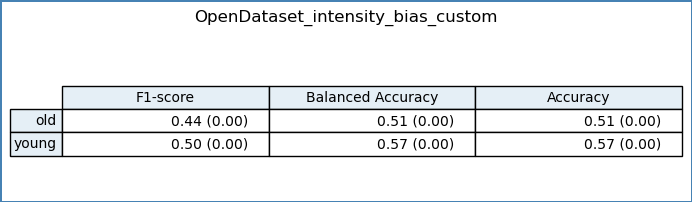

In [24]:
saver.toImage()